In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

/Users/marcosf/Desktop/ai-cookbook/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^https://.+'

In [3]:
# Define root domain to crawl
domain = "karpathy.ai"
full_url = f"https://{domain}"

In [4]:
# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
  def __init__(self):
    super().__init__()
    # Create a set to store the hyperlinks
    self.links = set()

  # Override the HTMLParser's handle_starttag method to get the hyperlinks
  def handle_starttag(self, tag, attrs):
    attrs = dict(attrs)

    # Check if the tag is an anchor tag and if it has an href attribute
    if tag == 'a' and 'href' in attrs:
      # Add the hyperlink to the set
      self.links.add(attrs['href'])
  

In [5]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
  # Try to open the URL and read the HTML
  try:
    # Open the URL and read the HTML
    with urllib.request.urlopen(url) as response:
      # If the response is not HTML, return an empty list
      if not response.info().get("Content-Type").startswith("text/html"):
        return []

      # Decode the response and process the HTML
      html = response.read().decode("utf-8")
  except Exception as e:
    print(e)
    return []

  # Create the HTML parser and then parse the HTML to get the hyperlinks
  parser = HyperlinkParser()
  parser.feed(html)

  return parser.links

In [6]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
  clean_links = []

  for link in get_hyperlinks(url):
    clean_link = None

    # If link is a # or none, skip it
    if link == "#" or link is None:
      continue

    # If link is a URL, check if it is within the same domain
    if re.search(HTTP_URL_PATTERN, link):
      # Parse the URL and check if the domain is the same
      url_obj = urlparse(link)
      
      if url_obj.netloc.find(local_domain) != -1:
        clean_link = link

    if clean_link is not None:
      if clean_link.endswith("/"):
        clean_link = clean_link[:-1]
      clean_links.append(clean_link)

  # Return the list of hyperlinks that are within the same domain
  return list(set(clean_links))
    

In [7]:
def crawl(url):
  # Parse the URL and get the domain
  local_domain = urlparse(url).netloc

  # Create a queue to store the URLs to crawl
  queue = deque([url])

  # Create a set to store the URLs that have already been seen (no duplicates)
  seen = set([url])

  # Create a directory to store the text files
  if not os.path.exists("text/"):
    os.mkdir("text/")

  if not os.path.exists(f"text/{local_domain}/"):
    os.mkdir(f"text/{local_domain}/")

  # Create a directory to store the csv files
  if not os.path.exists("processed"):
    os.mkdir("processed")

  # While the queue is not empty and the crawler has not seen more than 50 URLs, continue crawling
  counter = 0
  while queue and counter < 2:

    # Get the next URL from the queue
    url = queue.pop()
    print(url) # for debugging and to see the progress

    # Save text from the url to a <url>.txt file
    filename = url[8:].replace("/", "_")
    
    if len(filename) < 100:
      with open(f"text/{local_domain}/{filename}.txt", "w") as f:
        try:
          # Get the text from the URL using BeautifulSoup
          soup = BeautifulSoup(requests.get(url).text, "html.parser")

          # Get the text but remove the tags
          text = soup.get_text()

          # If the crawler gets to a page that requires JavaScript, it will stop the crawl
          if ("You need to enable JavaScript to run this app." in text):
            print("Unable to parse page " + url + " due to JavaScript being required")
                
          # Otherwise, write the text to the file in the text directory
          f.write(text)
          counter += 1

        except Exception as e:
          print("Unable to parse page " + url + " due to " + str(e))

    # Get the hyperlinks from the URL and add them to the queue
    for link in get_domain_hyperlinks(local_domain, url):
      if link not in seen:
        queue.append(link)
        seen.add(link)

In [8]:
crawl(full_url)

https://karpathy.ai


In [9]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [10]:
import pandas as pd


# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
folder_path = f"text/{domain}/"
for file in os.listdir(folder_path):
    prefix = file.find(domain) + len(domain)
    base_name = file[prefix:-4].replace('-',' ').replace('_', ' ').replace('#update','').lstrip()
    if not base_name:
        base_name = file[:-4]
    
    # Open the file and read the text
    with open(folder_path + file, "r") as f:
        text = f.read()
        texts.append((base_name, text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with newlines removed
df['text'] = remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,karpathy.ai,Andrej Karpathy Andrej Karpathy I like...


<Axes: >

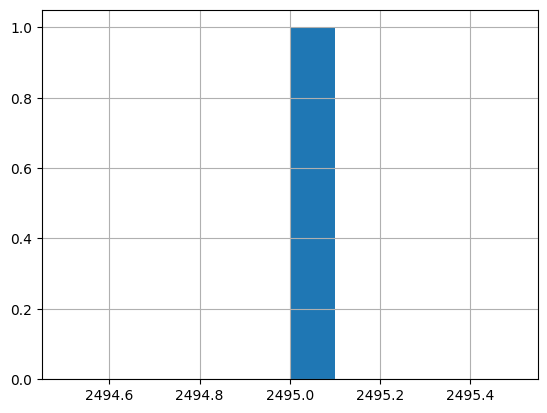

In [11]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [12]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):
        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1
    
    chunks.append(". ".join(chunk) + ".")

    return chunks

shortened = []

# Loop through the dataframe
for row in df.iterrows():
    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

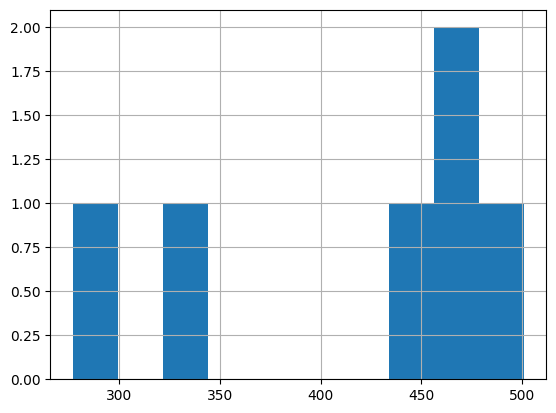

In [13]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [14]:
df.head(6)

,text,n_tokens
0,Andrej Karpathy Andrej Karpathy I like...,459
1,Along the way I squeezed in 3 inter...,452
2,my 2016 lecture videos course notes course...,478
3,This enables nice web-based demos that train c...,329
4,"Kingma, and Yaroslav Bulatov Connecting Image...",501
5,I enumerated and sorted sci-fi books I've read...,277


In [ ]:
import openai

openai.api_key=os.environ.get("OPENAI_API_KEY")

df['embeddings'] = df.text.apply(lambda text: openai.Embedding.create(input=text, model='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

df.head()

In [ ]:
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, model='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')

    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Who is Andrej Karpathy?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [ ]:
answer_question(df)

In [ ]:
answer_question(df, question="Who is Bill Clinton?")